##Data Science Assignment: Trader Behavior Insights

**Objective** **:**




Analyze how trading behavior (profitability, risk, volume) aligns or diverges from overall market sentiment (Fear vs Greed).



In [ ]:
#1.Importing libraries and setting path


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [12, 6]
DATA_DIR = "dataset_files"
OUTPUT_DIR = "outputs"
FILE_OUTPUT = "csv_files"

os.makedirs(OUTPUT_DIR, exist_ok=True)


In [ ]:
#2.Loading Data


try:
    hist_df = pd.read_csv(os.path.join(DATA_DIR, "historical_data.csv"))
    hist_df.columns = hist_df.columns.str.strip()
    print(f"Historical Data loaded: {hist_df.shape}")

    fg_df = pd.read_csv(os.path.join(DATA_DIR, "fear_greed_index.csv"))
    fg_df.columns = fg_df.columns.str.strip()
    print(f"Fear & Greed Data loaded: {fg_df.shape}")
except Exception as e:
    print(f"Error loading data: {e}")


Historical Data loaded: (211224, 16)
Fear & Greed Data loaded: (2644, 4)


In [ ]:
#3.Data Preprocessing


hist_df['Timestamp'] = pd.to_datetime(hist_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
hist_df['Date'] = hist_df['Timestamp'].dt.date

numeric_cols = ['Execution Price', 'Size USD', 'Closed PnL', 'Fee']
for col in numeric_cols:
    if col in hist_df.columns and hist_df[col].dtype == object:
         hist_df[col] = hist_df[col].replace(r'[\$,]', '', regex=True).astype(float)

if 'date' in fg_df.columns:
    fg_df['Date'] = pd.to_datetime(fg_df['date']).dt.date
elif 'timestamp' in fg_df.columns:
    fg_df['Date'] = pd.to_datetime(fg_df['timestamp'], unit='s').dt.date

print("Data preprocessed and dates aligned.")


Data preprocessed and dates aligned.


In [ ]:
#4.Analysis & Visualization


daily_trading = hist_df.groupby('Date').agg(
    Total_Volume=('Size USD', 'sum'),
    Trade_Count=('Account', 'count'),
    Total_PnL=('Closed PnL', 'sum'),
    Avg_PnL=('Closed PnL', 'mean')
).reset_index()


long_short = hist_df.groupby(['Date', 'Side']).size().unstack(fill_value=0)
if 'BUY' in long_short.columns and 'SELL' in long_short.columns:
    long_short['LS_Ratio'] = long_short['BUY'] / (long_short['SELL'] + 1e-9)
else:
    long_short['LS_Ratio'] = 0

daily_trading = daily_trading.merge(long_short[['LS_Ratio']], on='Date', how='left')


merged_df = daily_trading.merge(fg_df[['Date', 'value', 'classification']], on='Date', how='inner')
merged_df = merged_df.sort_values('Date')

print(f"Merged Dataset: {merged_df.shape}")

merged_df.to_csv(os.path.join(FILE_OUTPUT, "final_analysis_output.csv"), index=False)


Merged Dataset: (479, 8)


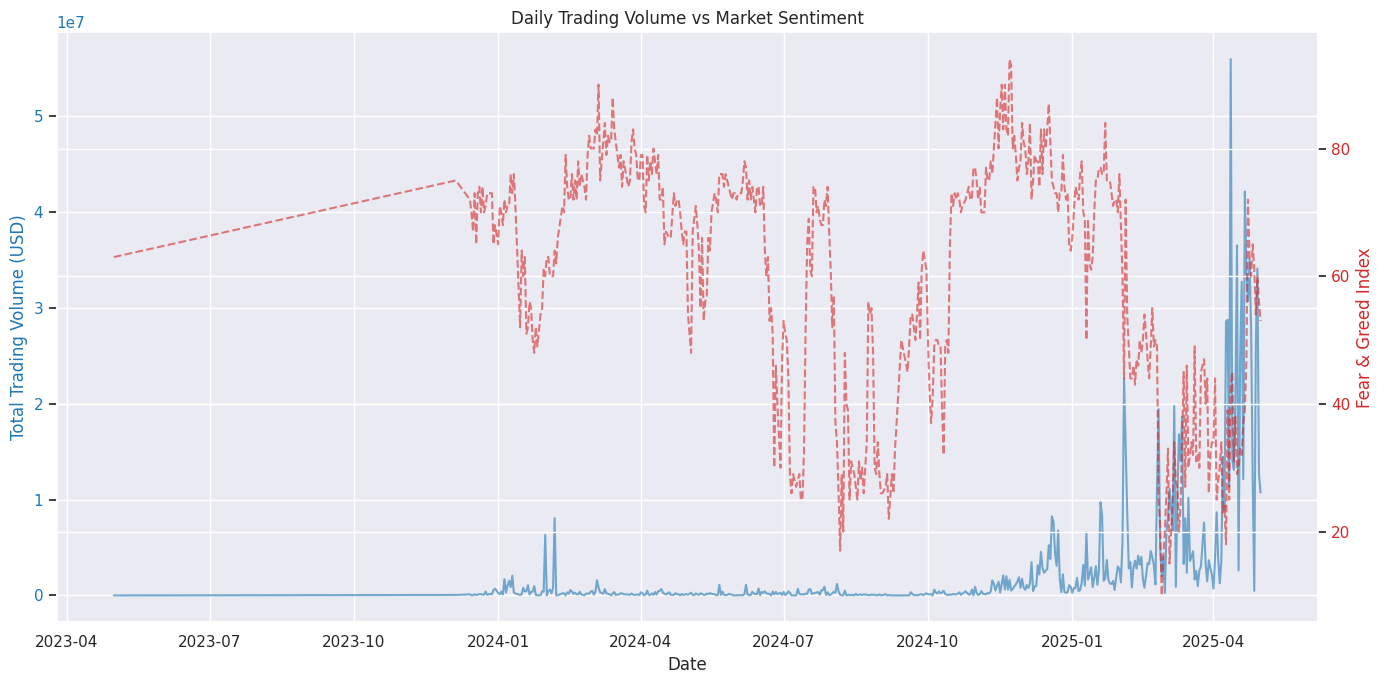

In [ ]:
#Plot 1: Trading volume vs Fear & greed index - subplot


fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Trading Volume (USD)', color=color)
ax1.plot(merged_df['Date'], merged_df['Total_Volume'], color=color, alpha=0.6, label='Volume')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Fear & Greed Index', color=color)
ax2.plot(merged_df['Date'], merged_df['value'], color=color, alpha=0.6, linestyle='--', label='F&G Index')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Daily Trading Volume vs Market Sentiment')
fig.tight_layout()
plt.show()


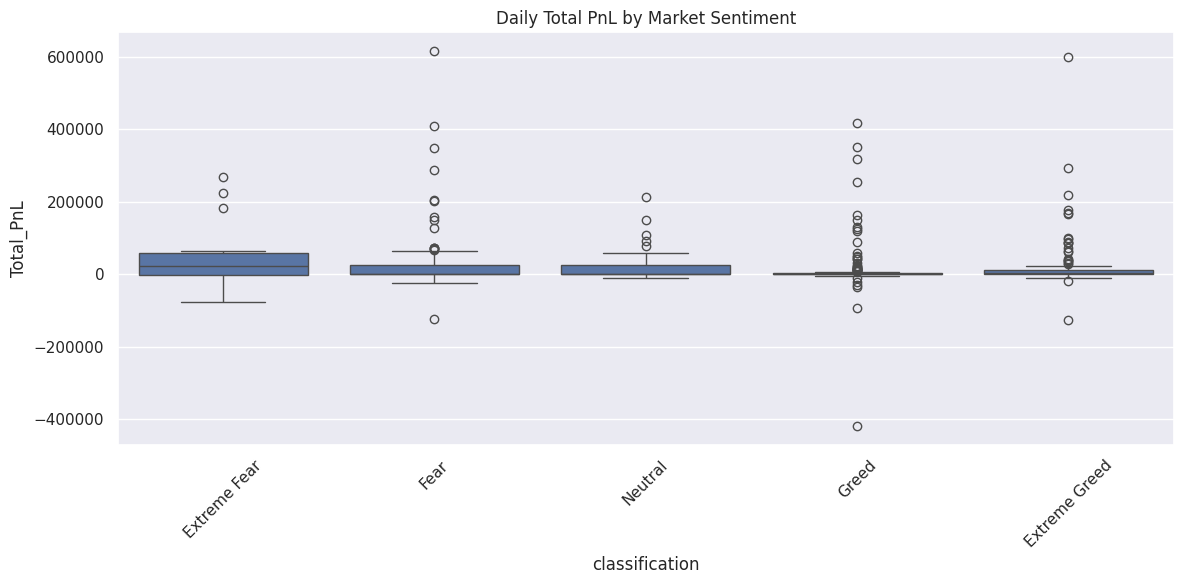

In [ ]:
#Plot 2: PnL Distribution by Sentiment - boxplot

plt.figure(figsize=(12, 6))
sns.boxplot(x='classification', y='Total_PnL', data=merged_df, order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Daily Total PnL by Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


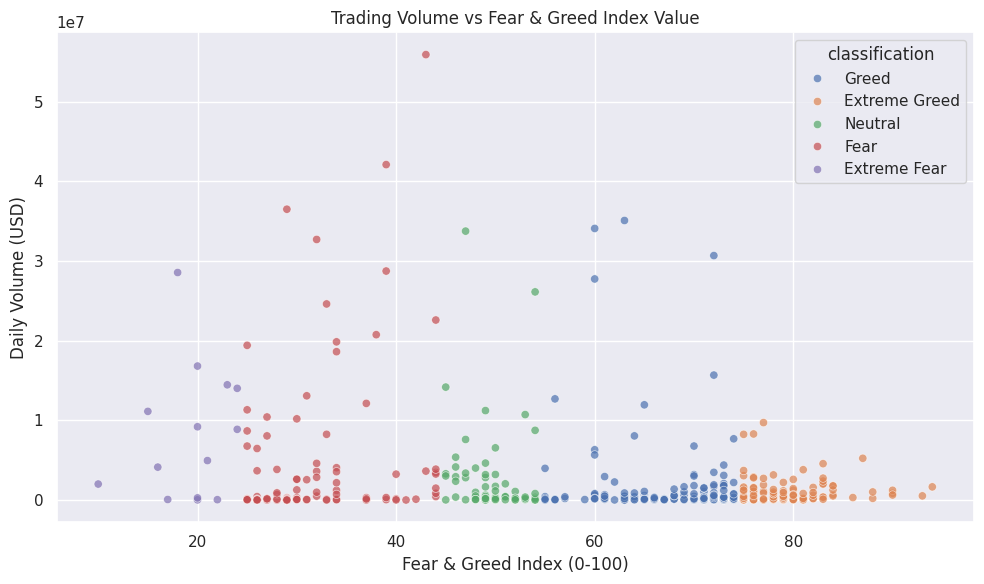

In [ ]:
#Plot 3: Trading Volume vs Fear & Greed Index Value - scatter plot

plt.figure(figsize=(10, 6))
sns.scatterplot(x='value', y='Total_Volume', data=merged_df, hue='classification', alpha=0.7)
plt.title('Trading Volume vs Fear & Greed Index Value')
plt.xlabel('Fear & Greed Index (0-100)')
plt.ylabel('Daily Volume (USD)')
plt.tight_layout()
plt.show()
